In [1]:
# Configure task - change this to any available task
TASK_NAME = 'SO100HandOverBanana'  # Options: 'SO100HandOverBanana', 'SO100HandOverApple', etc.

import sys
import os

from scripts.so101_lerobot_wrapper import SO101LeRobotWrapper
import numpy as np
import time
from scripts.image_utils import display_images, tensor_to_pil

In [2]:
lerobot = SO101LeRobotWrapper(
    task_name=TASK_NAME,
    cameras=('overhead_cam', 'front_cam', 'wrist_cam'),
    camera_resolution=(480, 640),
    device='cpu'
)

obs = lerobot.reset()

   Cameras: ('overhead_cam', 'front_cam', 'wrist_cam')
   Resolution: (480, 640)
   Device: cpu


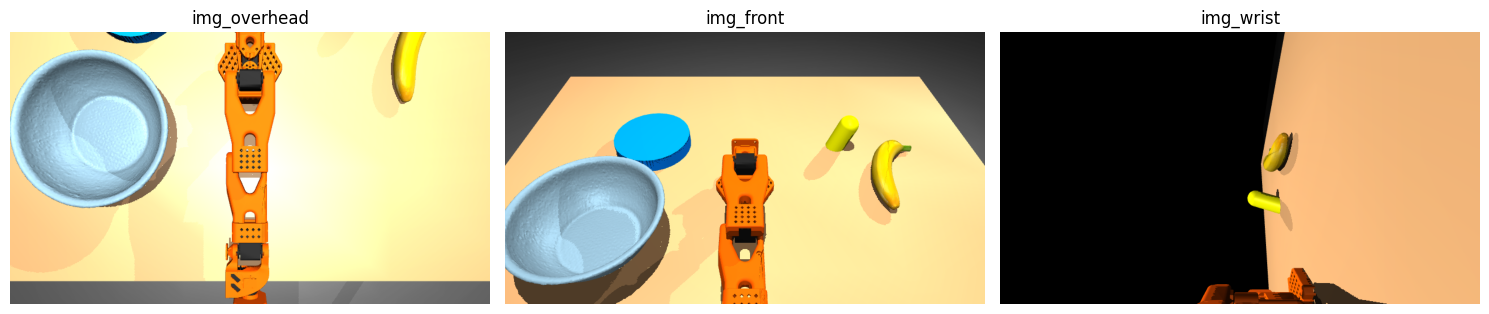

In [3]:
def plot_images(obs):
    img_overhead = tensor_to_pil(obs['observation.images.overhead_cam'])
    img_front = tensor_to_pil(obs['observation.images.front_cam'])
    img_wrist = tensor_to_pil(obs['observation.images.wrist_cam'])

    # Display all camera views
    display_images(img_overhead, img_front, img_wrist)

plot_images(obs)

In [7]:
for key in obs: print(key)

observation.images.overhead_cam
observation.images.front_cam
observation.images.wrist_cam
observation.state
action
timestamp
frame_index
episode_index
index
task_index
task


In [9]:
# Movement sequence: move towards banana, grab it, move to bowl, drop it
def generate_mock_action(step, total_steps):
    """Generate simple action sequence for banana handover."""
    progress = step / total_steps
    
    # Phase 1 (0-30%): Move towards banana
    if progress < 0.3:
        t = progress / 0.3
        return np.array([
            0.1 * np.sin(t * np.pi),      # slight rotation
            0.2 * t,                      # move arm down/forward
            0.1 * t,                      # elbow movement
            0.0,                          # wrist
            0.0,                          # wrist roll
            0.08 * (1 - t)               # open gripper initially
        ])
    
    # Phase 2 (30-50%): Grab banana
    elif progress < 0.5:
        t = (progress - 0.3) / 0.2
        return np.array([
            0.1 * np.sin(0.3 * np.pi),   # hold position
            0.2 * 0.3,                   # hold position  
            0.1 * 0.3,                   # hold position
            0.0,
            0.0,
            0.08 * (1 - t)               # close gripper
        ])
    
    # Phase 3 (50-80%): Move to bowl
    elif progress < 0.8:
        t = (progress - 0.5) / 0.3
        return np.array([
            0.1 * np.sin(0.3 * np.pi) + 0.3 * t,  # rotate towards bowl
            0.2 * 0.3 - 0.1 * t,                  # lift up slightly
            0.1 * 0.3 + 0.2 * t,                  # extend arm
            0.1 * t,                              # wrist adjustment
            0.0,
            0.0                                   # keep gripper closed
        ])
    
    # Phase 4 (80-100%): Drop banana
    else:
        t = (progress - 0.8) / 0.2
        return np.array([
            0.1 * np.sin(0.3 * np.pi) + 0.3 * 0.3,  # hold position
            0.2 * 0.3 - 0.1 * 0.3,                  # hold position
            0.1 * 0.3 + 0.2 * 0.3,                  # hold position  
            0.1 * 0.3,                              # hold position
            0.0,
            0.08 * t                                # open gripper to drop
        ])


Time: 0.0s | Step: 0


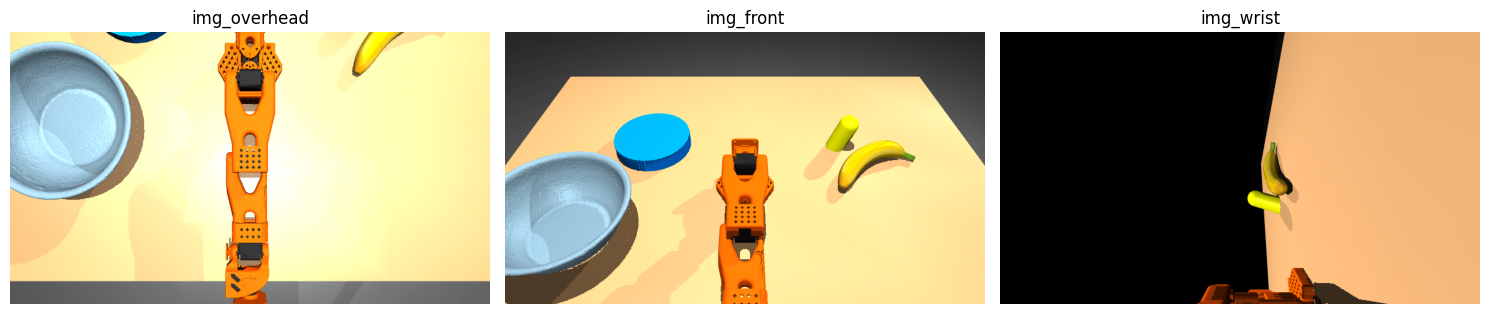

KeyboardInterrupt: 

In [10]:
INFERENCE_DURATION = 10.0
FPS = 30
DISPLAY_INTERVAL = 3.0
dt = 1.0 / FPS

total_steps = int(INFERENCE_DURATION * FPS)
last_display_time = 0

for step in range(total_steps):
    current_time = step * dt
    action = generate_mock_action(step, total_steps)
    obs = lerobot.step(action)
    
    if current_time - last_display_time >= DISPLAY_INTERVAL or step == 0:
        print(f"Time: {current_time:.1f}s | Step: {step}")
        plot_images(obs)
        last_display_time = current_time
    
    time.sleep(dt)